In [2]:
import sys
sys.path.append('C:/maldb/python/mlp/')

import tensorflow as tf
from tensorflow import keras

import numpy as np
np.set_printoptions(threshold=np.inf)

from ionizer import *

In [3]:
#To avoid feeding wildly varying numbers into the NN, we normalize things by subtracting the mean from each feature value and dividing by the standard deviation
def normalize_data(data):
    mean = data.mean(axis=0)
    data -= mean

    std = data.std(axis=0)
    data /= std
    
    return data

#When we shuffle our training and test arrays, we need to shuffle them in unison so that the indices in the labels array line up with their corresponding peptide in the training array.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def aa_to_int(char):
    aa_map = {
    'A': 0,
    'C': 1,
    'D': 2,
    'E': 3,
    'F': 4,
    'G': 5,
    'H': 6,
    'I': 7,
    'K': 8,
    'L': 9,
    'M': 10,
    'N': 11,
    'P': 12,
    'Q': 13,
    'R': 14,
    'S': 15,
    'T': 16,
    'V': 17,
    'W': 18,
    'Y': 19
}
    
    return(aa_map[char])

def pad_peptide(arr, max_dim=64):
    return np.pad(arr, [(0, max_dim - arr.shape[0]), (0, 0)])

def one_hot_padded_sequence(seq):
    chars = []
    chars[:] = seq
    aaints = np.vectorize(aa_to_int)(chars)
    one_hot = keras.utils.to_categorical(aaints, num_classes=20)
    return pad_peptide(one_hot)
    
def vectorize_sequences(seqs):
    vectorized = []
    for seq in seqs:
        vectorized.append(one_hot_padded_sequence(seq))
    return np.array(vectorized)

In [6]:
#Get the data from the excel sheet, calculate feature vectors for each entry (row) using ionizers.py
train_data, train_seqs, train_labels = get_ionizer_training_data('C:/maldb/python/mlp/data/ionizers.csv')

#Let's vectorize our sequences
train_seqs_vec = vectorize_sequences(train_seqs)

#Let's check out how many samples we have and the number of features we're getting from our feature vectors.
print(train_data.shape) 
print(train_seqs_vec.shape)

#Assign these values into variables for later.
#num_samples will be used to split the data into partitions.
#feature_vector_length is required to tell the input layer what shape it is expected to receive
num_samples = train_data.shape[0]
feature_vector_length = train_data.shape[1]


split = round(0.50 * num_samples) #makes an 85/15 split of the dataset

(666, 559)
(666, 64, 20)


In [8]:
x_train = normalize_data(train_data).astype('float32')
y_train = train_labels.astype('float32')

In [11]:
from keras import models
from keras import layers
from keras import regularizers

#Lets make our dense model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(feature_vector_length,)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy', 
        keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
    ]
)

In [28]:
#Lets build a 1D convolutional model
from keras.optimizers import RMSprop

cmodel = models.Sequential()
cmodel.add(layers.Conv1D(1, kernel_size=3, activation="relu", input_shape=(64,20)))
cmodel.add(layers.MaxPooling1D(5))
cmodel.add(layers.Dense(1, activation="sigmoid"))

cmodel.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)],
)

cmodel.fit(
    train_seqs_vec,
    train_labels,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
17/17 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.6447 - binary_accuracy: 0.6447 - val_loss: 0.6845 - val_accuracy: 0.6940 - val_binary_accuracy: 0.6940
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.6447 - binary_accuracy: 0.6447 - val_loss: 0.6792 - val_accuracy: 0.6940 - val_binary_accuracy: 0.6940
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.6447 - binary_accuracy: 0.6447 - val_loss: 0.6748 - val_accuracy: 0.6940 - val_binary_accuracy: 0.6940
Epoch 4/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6447 - binary_accuracy: 0.6447 - val_loss: 0.6703 - val_accuracy: 0.6940 - val_binary_accuracy: 0.6940
Epoch 5/10
17/17 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.6447 - binary_accuracy: 0.6447 - val_loss: 0.6665 - val_accuracy: 0.6940 - val_binary_accuracy: 0.6940
Epoch 6/10
17/17 [==

In [11]:
#We should randomly shuffle our data before splitting it into training and test sets
#The peptides were deposited into the array on a per-protein basis, so each protein may have a specific AA composition, properties etc.
#Thus, if the first 85% of our data were soluble proteins, and the last 15% were membrane proteins, we are likely to have poor prediction since our model never saw/had a chance to learn on membrane peptides!

#Shuffle!
x_train, y_train = unison_shuffled_copies(x_train, y_train)

In [16]:
#Slice the training and validation sets
partial_x_train = x_train[:split]
x_val = x_train[split:]

partial_y_train = y_train[:split]
y_val = y_train[split:]

In [17]:
#Train the convolutional model


21/21 [==============================] - 0s 2ms/step - loss: 9.9830 - accuracy: 0.3453


In [18]:
#Train the dense model
epochs = 20
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, validation_split=0.2)

Epoch 1/20
9/9 [==============================] - 0s 17ms/step - loss: 2.3222 - accuracy: 0.7068 - binary_accuracy: 0.7068 - val_loss: 2.3492 - val_accuracy: 0.6716 - val_binary_accuracy: 0.6716
Epoch 2/20
9/9 [==============================] - 0s 3ms/step - loss: 2.0331 - accuracy: 0.7368 - binary_accuracy: 0.7368 - val_loss: 2.2143 - val_accuracy: 0.7164 - val_binary_accuracy: 0.7164
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 1.9585 - accuracy: 0.7744 - binary_accuracy: 0.7744 - val_loss: 2.3186 - val_accuracy: 0.4925 - val_binary_accuracy: 0.4925
Epoch 4/20
9/9 [==============================] - 0s 5ms/step - loss: 1.8220 - accuracy: 0.8158 - binary_accuracy: 0.8158 - val_loss: 1.9171 - val_accuracy: 0.6866 - val_binary_accuracy: 0.6866
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 1.7030 - accuracy: 0.8459 - binary_accuracy: 0.8459 - val_loss: 1.8317 - val_accuracy: 0.7313 - val_binary_accuracy: 0.7313
Epoch 6/20
9/9 [=============

dict_keys(['loss', 'accuracy', 'binary_accuracy', 'val_loss', 'val_accuracy', 'val_binary_accuracy'])


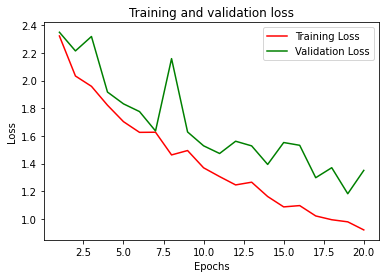

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

e = range(1, epochs + 1)

plt.plot(e, loss_values, 'r-', label='Training Loss')
plt.plot(e, val_loss_values, 'g-', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


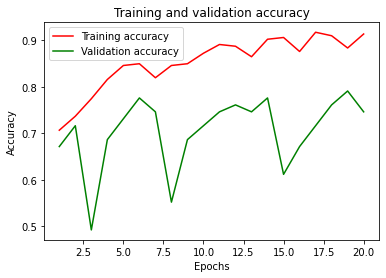

In [20]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(e, acc_values, 'r-', label='Training accuracy')
plt.plot(e, val_acc_values, 'g-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

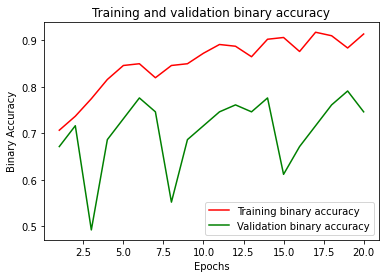

In [21]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_binary_accuracy']
plt.plot(e, acc_values, 'r-', label='Training binary accuracy')
plt.plot(e, val_acc_values, 'g-', label='Validation binary accuracy')
plt.title('Training and validation binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

In [37]:
print(np.array(val_acc_values).mean())
model.predict(np.array([x_train[45]]))

0.7075074970722198


array([[0.13889986]], dtype=float32)

(array([51., 35., 17., 20.,  8.,  6.,  7.,  9.,  7.,  5.,  6., 10.,  8.,
         2.,  9.,  5.,  6.,  4.,  5.,  6.,  4.,  4.,  4.,  5.,  4.,  2.,
         3.,  2.,  1.,  5.,  4.,  7.,  5.,  3.,  2.,  7.,  3.,  5.,  3.,
         3.,  2.,  2.,  3.,  5.,  6.,  3.,  1.,  2.,  2.,  5.]),
 array([1.10928086e-04, 2.00213548e-02, 3.99317816e-02, 5.98422103e-02,
        7.97526389e-02, 9.96630639e-02, 1.19573489e-01, 1.39483914e-01,
        1.59394339e-01, 1.79304779e-01, 1.99215204e-01, 2.19125628e-01,
        2.39036053e-01, 2.58946478e-01, 2.78856903e-01, 2.98767328e-01,
        3.18677753e-01, 3.38588178e-01, 3.58498633e-01, 3.78409058e-01,
        3.98319483e-01, 4.18229908e-01, 4.38140333e-01, 4.58050758e-01,
        4.77961183e-01, 4.97871608e-01, 5.17782032e-01, 5.37692487e-01,
        5.57602882e-01, 5.77513337e-01, 5.97423732e-01, 6.17334187e-01,
        6.37244582e-01, 6.57155037e-01, 6.77065432e-01, 6.96975887e-01,
        7.16886282e-01, 7.36796737e-01, 7.56707191e-01, 7.76617587e-

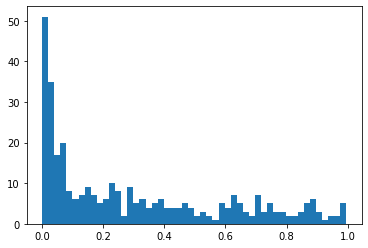

In [38]:
plt.hist(model.predict(x_val), bins=50)